# Network-Constrained Optimization

Power system optimization becomes significantly more complex when we account for the physical limitations of the transmission network. While economic dispatch finds the cheapest generation mix, it assumes perfect transmission - an assumption that breaks down in congested networks. This lesson bridges that gap by introducing optimization techniques that respect transmission constraints while maintaining system security.

Modern electricity markets rely on these network-constrained optimization algorithms to clear billions of dollars in energy transactions daily. The Security-Constrained Economic Dispatch (SCED) you'll implement here runs every five minutes in major grid control rooms, determining which generators produce power and at what price consumers pay. Understanding these algorithms is essential for anyone working with power system operations, electricity markets, or renewable energy integration.

## Learning Objectives

| Information | Details |
|-------------|----------|
| Prerequisites | Linear programming with PuLP, PTDF concepts, basic economic dispatch |
| Learning Objectives | • Understand why network constraints matter in power system optimization<br>• Implement Security-Constrained Economic Dispatch using PTDF<br>• Apply N-1 contingency analysis with LODF<br>• Formulate and solve DC Optimal Power Flow problems<br>• Handle renewable uncertainty in network-constrained settings |
| Estimated Time | 120 minutes |
| Topics | Network congestion, SCED, contingency analysis, DC OPF, stochastic optimization |

## Setup and Utilities

We begin by importing necessary libraries and defining a minimal set of utility functions that will be reused throughout this lesson. These utilities handle common tasks like creating test networks, calculating sensitivity factors, and visualizing results. More specialized functions will be defined inline where they're used, keeping each section self-contained and easier to understand.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

This notebook reuses the PTDF and LODF calculation functions from the [PTDF](ptdf.ipynb) lesson. We include it in this notebook using the `%run` magic.

Bus Data:
      bus_id  bus_type  demand
Bus1       1         3       0
Bus2       2         1     100
Bus3       3         1      80

Line Data:
   from_bus to_bus  reactance  limit
L1     Bus1   Bus2       0.10    120
L2     Bus1   Bus3       0.15    100
L3     Bus2   Bus3       0.20     80
B Matrix (Susceptance Matrix):
         Bus1  Bus2     Bus3
Bus1  16.6667 -10.0  -6.6667
Bus2 -10.0000  15.0  -5.0000
Bus3  -6.6667  -5.0  11.6667

Matrix properties:
- Symmetric: True
- Singular (rows sum to 0): True
Slack bus identified: Bus1 (index 0)

PTDF Matrix:
           Bus1    Bus2    Bus3
Bus1-Bus2   0.0 -0.7778 -0.3333
Bus1-Bus3   0.0 -0.2222 -0.6667
Bus2-Bus3   0.0  0.2222 -0.3333
PTDF Validation:
1. Row sums (should be ≈ 0 for power conservation):
   L1: -1.111111
   L2: -0.888889
   L3: -0.111111

2. Test injection: 100 MW at Bus2
   (Slack bus automatically provides -100 MW)
   Resulting line flows:
   L1: -77.78 MW
   L2: -22.22 MW
   L3: 22.22 MW

3. Power balance at each bus:
  

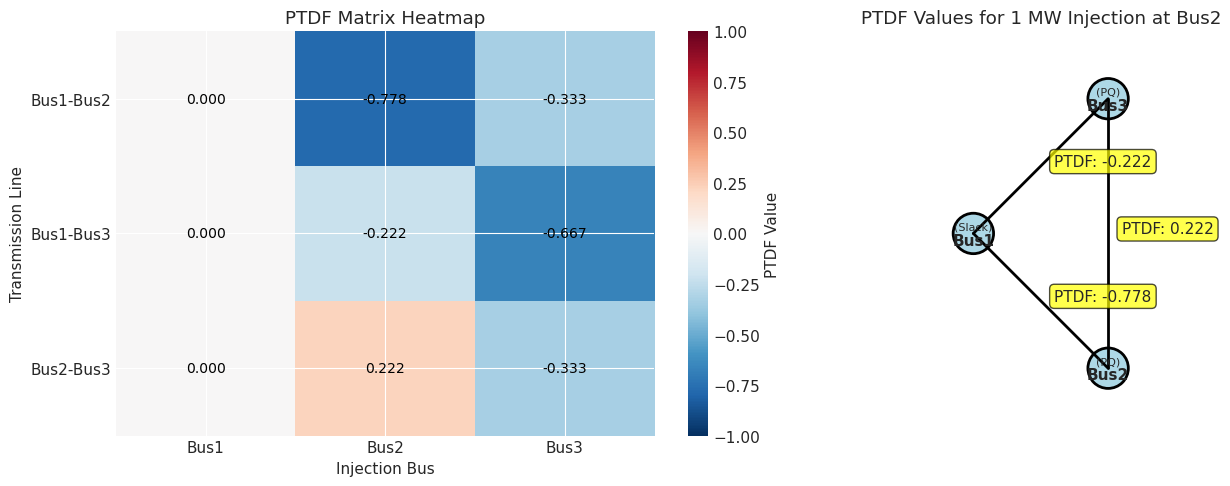

Generation Shift Factors (Bus3 → Bus1):
L1: 0.3333
L2: 0.6667
L3: 0.3333

Interpretation:
Shifting 10 MW from Bus3 to Bus1 would change flows by:
L1: +3.33 MW
L2: +6.67 MW
L3: +3.33 MW
LODF Matrix:
(Row = monitored line, Column = outaged line)
           Bus1-Bus2  Bus1-Bus3  Bus2-Bus3
Bus1-Bus2       -1.0        1.0       -1.0
Bus1-Bus3        1.0       -1.0        1.0
Bus2-Bus3       -1.0        1.0       -1.0
Base Case Flows:
L1: 77.78 MW (Limit: 120 MW)
L2: 22.22 MW (Limit: 100 MW)
L3: -22.22 MW (Limit: 80 MW)

Contingency Analysis: Outage of L1
Pre-contingency flow on outaged line: 77.78 MW

  Line  Base Flow (MW)  Post-Cont Flow (MW)  Change (MW)  Limit (MW)  \
0   L1           77.78                  0.0       -77.78         120   
1   L2           22.22                100.0        77.78         100   
2   L3          -22.22               -100.0       -77.78          80   

   Post-Cont Loading (%)  
0                    0.0  
1                  100.0  
2                  125.0  

In [2]:
%run ptdf.ipynb

In [3]:
# General utility functions used across multiple sections

def create_test_network():
    """Create a simple 3-bus test network for examples."""
    buses = pd.DataFrame({
        'bus_id': [1, 2, 3],
        'bus_type': [3, 1, 1],  # Bus 1 is slack (type 3), others are PQ (type 1)
        'demand': [0, 100, 80]   # MW
    }, index=['Bus1', 'Bus2', 'Bus3'])
    
    generators = pd.DataFrame({
        'bus': ['Bus1', 'Bus1', 'Bus3'],
        'p_min': [0, 0, 0],
        'p_max': [200, 150, 150],
        'cost': [20, 25, 22]
    }, index=['G1', 'G2', 'G3'])
    
    lines = pd.DataFrame({
        'from_bus': ['Bus1', 'Bus1', 'Bus2'],
        'to_bus': ['Bus2', 'Bus3', 'Bus3'],
        'limit': [100, 100, 80],
        'reactance': [0.1, 0.15, 0.2]
    }, index=['L1', 'L2', 'L3'])
    
    return buses, generators, lines

def add_power_balance(prob, p_vars, demand, name="Power_Balance"):
    """Add power balance constraint to optimization problem."""
    prob += lpSum(p_vars.values()) == demand, name
    return prob

def solve_and_report(prob, name="Optimization"):
    """Solve optimization problem and report basic results."""
    prob.solve(PULP_CBC_CMD(msg=0))
    
    print(f"\n{name} Results:")
    print("=" * 40)
    print(f"Status: {LpStatus[prob.status]}")
    
    if prob.status == 1:  # Optimal
        print(f"Total cost: ${value(prob.objective):.2f}")
        if 'Power_Balance' in prob.constraints:
            lmp = prob.constraints['Power_Balance'].pi
            if lmp is not None:
                print(f"System LMP: ${lmp:.2f}/MWh")
    return prob.status == 1

def plot_network_flows(buses, lines, flows, title="Network Power Flows", ax=None):
    """Visualize power flows on network diagram."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Bus positions for visualization
    pos = {'Bus1': (0, 1), 'Bus2': (1, 0), 'Bus3': (1, 2)}
    
    # Draw buses
    for bus, (x, y) in pos.items():
        circle = plt.Circle((x, y), 0.15, color='lightblue', 
                           ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, bus, ha='center', va='center', fontweight='bold')
    
    # Draw lines with flows
    for i, (_, line) in enumerate(lines.iterrows()):
        x1, y1 = pos[line['from_bus']]
        x2, y2 = pos[line['to_bus']]
        
        # Line
        ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)
        
        # Flow annotation
        if i < len(flows):
            flow = flows[i]
            limit = line['limit']
            utilization = abs(flow) / limit * 100
            
            # Color based on utilization
            if utilization > 95:
                color = 'red'
            elif utilization > 80:
                color = 'orange'
            else:
                color = 'green'
            
            mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(mid_x + 0.1, mid_y, 
                   f"{flow:.1f} MW\n({utilization:.0f}%)",
                   bbox=dict(boxstyle="round,pad=0.3", 
                            facecolor='white', edgecolor=color),
                   ha='center', fontsize=9)
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    
    return ax

def plot_generation_dispatch(generators, dispatch, demand=None, title="Generation Dispatch", ax=None):
    """Create bar chart of generation dispatch."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    x = np.arange(len(generators))
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    bars = ax.bar(x, dispatch, color=colors[:len(dispatch)], 
                  edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, dispatch):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                   f'{val:.1f} MW', ha='center', va='bottom')
    
    if demand:
        ax.axhline(y=demand, color='red', linestyle='--', 
                  label=f'Demand: {demand} MW', linewidth=2)
        ax.legend()
    
    ax.set_xticks(x)
    ax.set_xticklabels(generators.index)
    ax.set_xlabel('Generator')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    return ax

## Building Intuition: Why Network Constraints Matter

Economic dispatch finds the cheapest way to meet demand by dispatching generators based solely on their costs. This works perfectly if we have infinite transmission capacity - but real transmission lines have thermal limits. When we ignore these limits, the optimization might dispatch cheap generation that can't physically reach the load, leading to overloaded lines and potential blackouts.

Let's demonstrate this problem with our test network. We'll first solve a simple economic dispatch ignoring transmission constraints, then check if the resulting power flows violate any line limits. This reveals why network-constrained optimization is essential for reliable grid operation.

In [4]:
# Load test network
buses, generators, lines = create_test_network()
total_demand = buses['demand'].sum()

print("Network Configuration:")
print(f"Total demand: {total_demand} MW\n")
print("Generators:")
print(generators[['bus', 'p_max', 'cost']])
print("\nTransmission Lines:")
print(lines[['from_bus', 'to_bus', 'limit']])

Network Configuration:
Total demand: 180 MW

Generators:
     bus  p_max  cost
G1  Bus1    200    20
G2  Bus1    150    25
G3  Bus3    150    22

Transmission Lines:
   from_bus to_bus  limit
L1     Bus1   Bus2    100
L2     Bus1   Bus3    100
L3     Bus2   Bus3     80


In [5]:
# Solve unconstrained economic dispatch
prob_ed = LpProblem("Simple_ED", LpMinimize)

# Variables
p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
         for g in generators.index}

# Objective: minimize cost
prob_ed += lpSum(generators.loc[g, 'cost'] * p_gen[g] 
                 for g in generators.index)

# Only constraint: meet demand
add_power_balance(prob_ed, p_gen, total_demand)

# Solve
solve_and_report(prob_ed, "Unconstrained Economic Dispatch")

# Extract dispatch
dispatch_ed = [value(p_gen[g]) for g in generators.index]
print("\nGenerator dispatch:")
for g, p in zip(generators.index, dispatch_ed):
    print(f"  {g}: {p:.1f} MW")


Unconstrained Economic Dispatch Results:
Status: Optimal
Total cost: $3600.00
System LMP: $20.00/MWh

Generator dispatch:
  G1: 180.0 MW
  G2: 0.0 MW
  G3: 0.0 MW


Now let's check what happens to line flows with this dispatch. We'll use the Power Transfer Distribution Factors (PTDF) to calculate how the power flows through the network. PTDF tells us what fraction of power injected at each bus flows through each line.

In [6]:
# Calculate line flows using PTDF
ptdf, slack_bus_idx = calculate_ptdf(buses, lines)

# Net injection at each bus (generation - demand)
net_injection = np.zeros(3)
for g_idx, g in enumerate(generators.index):
    bus = generators.loc[g, 'bus']
    bus_idx = ['Bus1', 'Bus2', 'Bus3'].index(bus)
    net_injection[bus_idx] += dispatch_ed[g_idx]

for b_idx, demand in enumerate(buses['demand']):
    net_injection[b_idx] -= demand

# Line flows = PTDF × net injections
line_flows_ed = ptdf @ net_injection

print("\nLine Flow Analysis:")
print("=" * 50)
violations = []
for i, line in enumerate(lines.index):
    flow = line_flows_ed[i]
    limit = lines.loc[line, 'limit']
    utilization = abs(flow) / limit * 100
    
    status = "⚠️ VIOLATION" if abs(flow) > limit else "✓ OK"
    print(f"{line}: {flow:6.1f} / {limit:3.0f} MW ({utilization:5.1f}%) {status}")
    
    if abs(flow) > limit:
        violations.append((line, flow, limit))

if violations:
    print(f"\n❌ Found {len(violations)} line limit violation(s)!")
    print("This dispatch is infeasible and would cause overloads.")
else:
    print("\n✓ All line flows within limits.")

Slack bus identified: Bus1 (index 0)

Line Flow Analysis:
L1:  104.4 / 100 MW (104.4%) ⚠️ VIOLATION
L2:   75.6 / 100 MW ( 75.6%) ✓ OK
L3:    4.4 /  80 MW (  5.6%) ✓ OK

❌ Found 1 line limit violation(s)!
This dispatch is infeasible and would cause overloads.


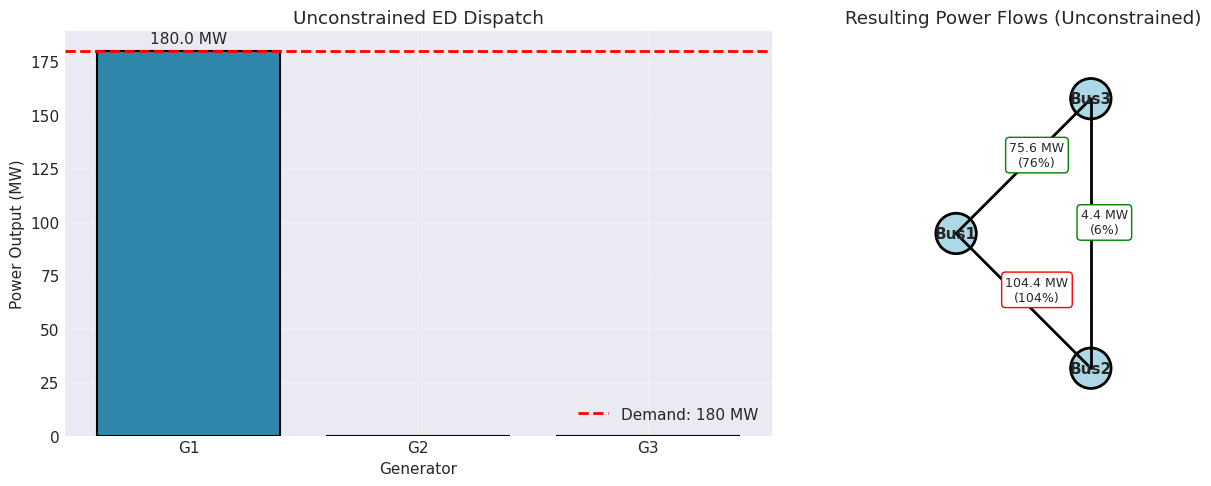

In [7]:
# Visualize the problem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Generation dispatch
plot_generation_dispatch(generators, dispatch_ed, total_demand, 
                        "Unconstrained ED Dispatch", ax1)
plt.sca(ax1)

# Network flows
plot_network_flows(buses, lines, line_flows_ed, 
                  "Resulting Power Flows (Unconstrained)", ax2)

plt.tight_layout()
plt.show()

The unconstrained economic dispatch violates transmission limits because it only considers generation costs, not network physics. This demonstrates why we need Security-Constrained Economic Dispatch (SCED), which we'll implement next.

## Security-Constrained Economic Dispatch (SCED)

Security-Constrained Economic Dispatch extends basic economic dispatch by explicitly modeling transmission constraints. SCED ensures that power flows respect line limits while still minimizing generation costs. The key innovation is using Power Transfer Distribution Factors (PTDF) to represent the linearized relationship between generator outputs and line flows through pre-computed sensitivity factors, keeping the problem computationally tractable even for large systems.

In real power systems, SCED runs every few minutes in control rooms, processing thousands of generators and transmission constraints to determine optimal dispatch and locational marginal prices (LMPs). The LMPs from SCED form the basis for electricity spot markets, determining what generators get paid and what consumers pay in different locations.

In [8]:
# Implement SCED with transmission constraints
def solve_sced(buses, generators, lines, ptdf):
    """Security-Constrained Economic Dispatch with line flow limits."""
    
    prob = LpProblem("SCED", LpMinimize)
    
    # Decision variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    
    # Objective: minimize generation cost
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] 
                  for g in generators.index)
    
    # Power balance constraint
    total_demand = buses['demand'].sum()
    add_power_balance(prob, p_gen, total_demand)
    
    # Calculate net injection at each bus as LP expressions
    net_injection = {}
    for bus in buses.index:
        # Generators at this bus
        gen_at_bus = generators[generators['bus'] == bus].index
        gen_sum = lpSum(p_gen[g] for g in gen_at_bus) if len(gen_at_bus) > 0 else 0
        
        # Net injection = generation - demand
        net_injection[bus] = gen_sum - buses.loc[bus, 'demand']
    
    # Line flow constraints using PTDF
    bus_list = list(buses.index)
    for line_idx, line in enumerate(lines.index):
        # Flow = sum(PTDF[line, bus] × net_injection[bus])
        flow = lpSum(ptdf[line_idx, bus_list.index(bus)] * net_injection[bus] 
                    for bus in buses.index)
        
        # Enforce line limits
        limit = lines.loc[line, 'limit']
        prob += flow <= limit, f"Flow_limit_pos_{line}"
        prob += flow >= -limit, f"Flow_limit_neg_{line}"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    dispatch = [value(p_gen[g]) for g in generators.index]
    
    # Calculate actual line flows
    net_inj_values = np.zeros(len(buses))
    for g_idx, g in enumerate(generators.index):
        bus_idx = bus_list.index(generators.loc[g, 'bus'])
        net_inj_values[bus_idx] += dispatch[g_idx]
    net_inj_values -= buses['demand'].values
    
    line_flows = ptdf @ net_inj_values
    
    return prob, dispatch, line_flows

In [9]:
# Solve SCED
prob_sced, dispatch_sced, flows_sced = solve_sced(buses, generators, lines, ptdf)
solve_and_report(prob_sced, "Security-Constrained Economic Dispatch");


Security-Constrained Economic Dispatch Results:
Status: Optimal
Total cost: $3626.67
System LMP: $20.00/MWh


In [10]:
# Compare ED vs SCED dispatch
print("\nDispatch Comparison:")
print("=" * 50)
print("Generator | Unconstrained ED | SCED      | Change")
print("-" * 50)
for g_idx, g in enumerate(generators.index):
    ed_val = dispatch_ed[g_idx]
    sced_val = dispatch_sced[g_idx]
    change = sced_val - ed_val
    print(f"{g:9s} | {ed_val:15.1f} | {sced_val:9.1f} | {change:+6.1f}")

print(f"\nTotal generation: {sum(dispatch_sced):.1f} MW")
print(f"ED cost: ${value(prob_ed.objective):.2f}")
print(f"SCED cost: ${value(prob_sced.objective):.2f}")
print(f"Cost increase from constraints: ${value(prob_sced.objective) - value(prob_ed.objective):.2f}")


Dispatch Comparison:
Generator | Unconstrained ED | SCED      | Change
--------------------------------------------------
G1        |           180.0 |     166.7 |  -13.3
G2        |             0.0 |       0.0 |   +0.0
G3        |             0.0 |      13.3 |  +13.3

Total generation: 180.0 MW
ED cost: $3600.00
SCED cost: $3626.67
Cost increase from constraints: $26.67


In [11]:
# Verify SCED respects line limits
print("\nSCED Line Flow Verification:")
print("=" * 50)
all_within_limits = True
for i, line in enumerate(lines.index):
    flow = flows_sced[i]
    limit = lines.loc[line, 'limit']
    utilization = abs(flow) / limit * 100
    
    status = "✓" if abs(flow) <= limit + 0.1 else "❌"
    print(f"{line}: {flow:6.1f} / {limit:3.0f} MW ({utilization:5.1f}%) {status}")
    
    if abs(flow) > limit + 0.1:
        all_within_limits = False

if all_within_limits:
    print("\n✓ All line flows within limits - SCED successful!")
else:
    print("\n❌ Some flows still exceed limits - check formulation")


SCED Line Flow Verification:
L1:  100.0 / 100 MW (100.0%) ✓
L2:   66.7 / 100 MW ( 66.7%) ✓
L3:    0.0 /  80 MW (  0.0%) ✓

✓ All line flows within limits - SCED successful!


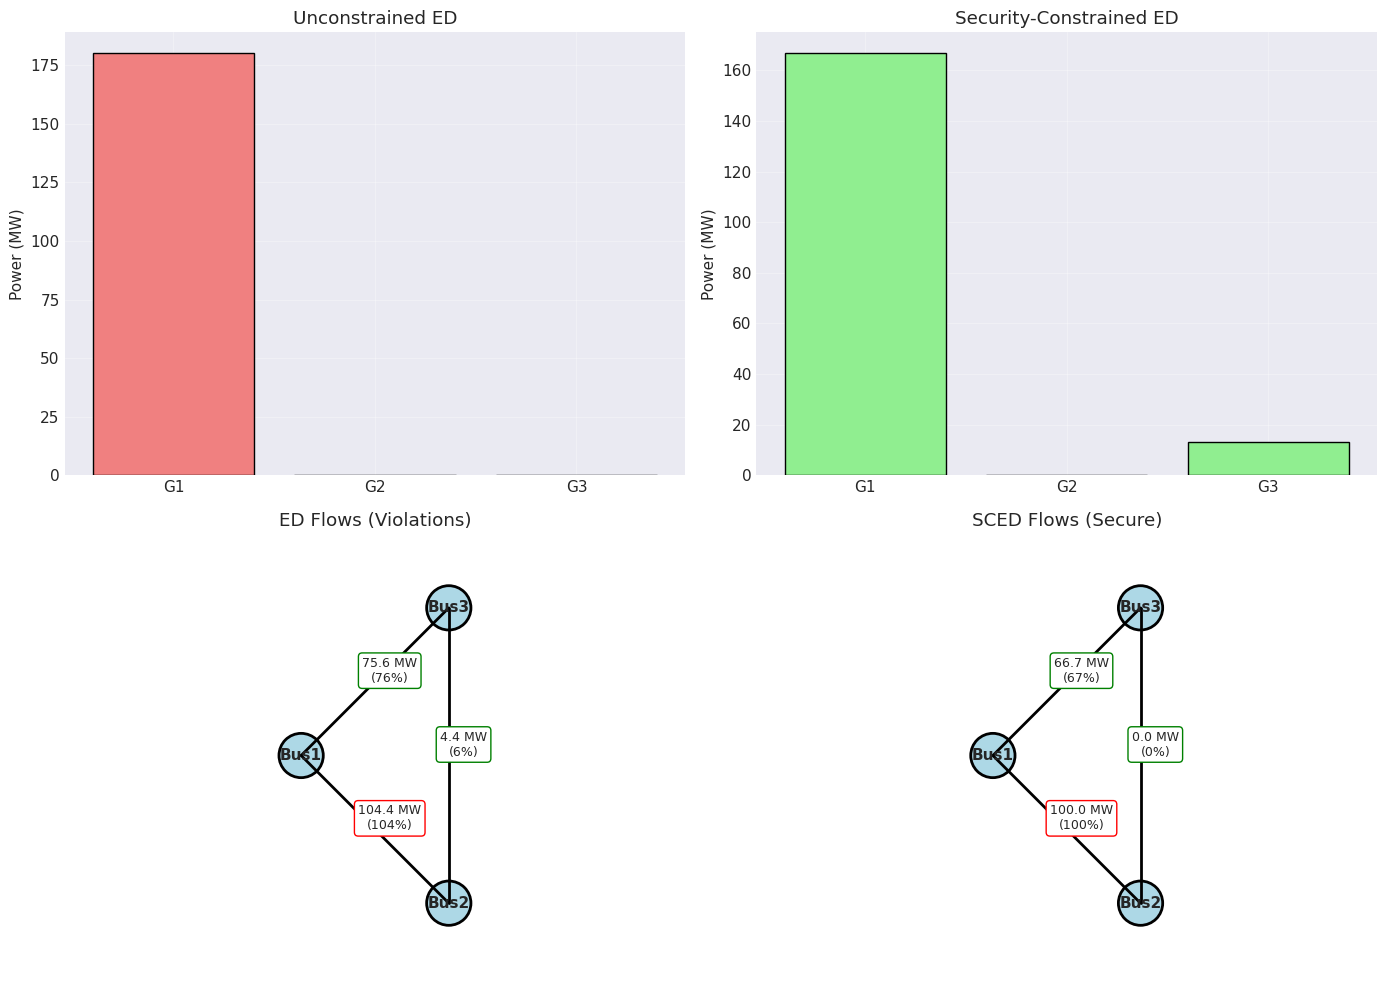

In [12]:
# Visualize SCED solution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ED dispatch
ax = axes[0, 0]
x = np.arange(len(generators))
ax.bar(x, dispatch_ed, color='lightcoral', edgecolor='black', label='ED')
ax.set_xticks(x)
ax.set_xticklabels(generators.index)
ax.set_ylabel('Power (MW)')
ax.set_title('Unconstrained ED')
ax.grid(True, alpha=0.3)

# SCED dispatch
ax = axes[0, 1]
ax.bar(x, dispatch_sced, color='lightgreen', edgecolor='black', label='SCED')
ax.set_xticks(x)
ax.set_xticklabels(generators.index)
ax.set_ylabel('Power (MW)')
ax.set_title('Security-Constrained ED')
ax.grid(True, alpha=0.3)

# ED network flows
plot_network_flows(buses, lines, line_flows_ed, 
                  "ED Flows (Violations)", axes[1, 0])

# SCED network flows
plot_network_flows(buses, lines, flows_sced, 
                  "SCED Flows (Secure)", axes[1, 1])

plt.tight_layout()
plt.show()

### Exercise 1: Multi-Period SCED with Ramping

Real power systems operate continuously, and generators cannot instantly change their output. Extend the SCED formulation to handle multiple time periods with ramping constraints. Consider a 4-hour horizon where demand varies and generators can only ramp up or down by 50 MW per hour.

Your implementation should minimize total cost across all periods while ensuring power balance, transmission limits, and ramping constraints are satisfied in each period. Pay special attention to how ramping constraints link decisions across time periods - this coupling is what makes multi-period problems more complex than solving each period independently.

**Hint:** Create variables p[g,t] for each generator g and time period t. Ramping constraints take the form |p[g,t] - p[g,t-1]| ≤ ramp_limit. Remember to handle the initial period separately using given initial conditions.

In [13]:
# Exercise 1: Your implementation here
def solve_multiperiod_sced():
    # Setup
    buses, generators, lines = create_test_network()
    ptdf = calculate_ptdf(buses, lines)
    
    # Demand profile over 4 hours
    demand_profile = [150, 180, 200, 160]  # MW
    ramp_limit = 50  # MW/hour
    initial_dispatch = [100, 0, 50]  # Initial generator outputs
    
    # Your implementation here
    pass

## N-1 Contingency Analysis

Power systems must remain secure not just under normal conditions, but also when equipment fails. The N-1 criterion requires that the system continue operating safely after losing any single component. This redundancy is fundamental to grid reliability - without it, a single line outage could cascade into widespread blackouts.

When a transmission line trips, its power flow instantly redistributes through the remaining network according to electrical laws, not economic dispatch. We use Line Outage Distribution Factors (LODF) to predict these flow redistributions without re-solving power flow for each contingency. LODF tells us what fraction of the tripped line's flow appears on each remaining line, enabling rapid contingency screening even for large systems.

In [14]:
def analyze_contingencies(base_flows, lines, lodf):
    """Analyze N-1 contingencies and identify violations."""
    n_lines = len(lines)
    violations = []
    
    print("N-1 Contingency Analysis:")
    print("=" * 60)
    
    for k in range(n_lines):  # Outaged line
        outaged = lines.index[k]
        outaged_flow = base_flows[k]
        
        print(f"\nOutage of {outaged} (carrying {outaged_flow:.1f} MW):")
        
        for l in range(n_lines):  # Monitored line
            if l == k:
                continue  # Outaged line has no flow
                
            monitored = lines.index[l]
            base_flow = base_flows[l]
            
            # Post-contingency flow = base + redistribution
            post_flow = base_flow + lodf[l, k] * outaged_flow
            
            # For illustration, we increase all the line limit by 25%
            # This number is arbitrary but should allow N-1 contingencies
            #   to solve.
            limit = lines.loc[monitored, 'limit'] * 1.25
            
            utilization = abs(post_flow) / limit * 100
            
            status = "⚠️ VIOLATION" if abs(post_flow) > limit else "✓"
            print(f"  {monitored}: {base_flow:6.1f} → {post_flow:6.1f} MW "
                  f"({utilization:5.1f}%) {status}")
            
            if abs(post_flow) > limit:
                violations.append((outaged, monitored, post_flow, limit))
    
    return violations

# Test N-1 with current SCED solution
lodf = calculate_lodf(ptdf, lines, buses)
violations = analyze_contingencies(flows_sced, lines, lodf)

if violations:
    print(f"\n❌ Found {len(violations)} N-1 violations")
    print("Current dispatch is not N-1 secure!")
else:
    print("\n✓ System is N-1 secure")

N-1 Contingency Analysis:

Outage of L1 (carrying 100.0 MW):
  L2:   66.7 →  166.7 MW (133.3%) ⚠️ VIOLATION
  L3:    0.0 → -100.0 MW (100.0%) ✓

Outage of L2 (carrying 66.7 MW):
  L1:  100.0 →  166.7 MW (133.3%) ⚠️ VIOLATION
  L3:    0.0 →   66.7 MW ( 66.7%) ✓

Outage of L3 (carrying 0.0 MW):
  L1:  100.0 →  100.0 MW ( 80.0%) ✓
  L2:   66.7 →   66.7 MW ( 53.3%) ✓

❌ Found 2 N-1 violations
Current dispatch is not N-1 secure!


::: {admonition} Modified line rating

The example three-bus three-line system is a small test case. Losing a line in a tightly constrained system can lead to infeasibility. Therefore, in the N-1 example shown below, we arbitrarily increased the line flow limit by 25%. This is typically not needed in large, interconnected grid.

:::

Since the basic SCED solution violates N-1 criteria, we need to add contingency constraints to ensure the system remains secure even after any single line outage. This is called N-1 SCED or Security-Constrained Economic Dispatch with contingencies.

In [15]:
def solve_n1_sced(buses, generators, lines, ptdf, lodf):
    """SCED with N-1 contingency constraints."""
    
    prob = LpProblem("N1_SCED", LpMinimize)
    
    # Variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] 
                  for g in generators.index)
    
    # Power balance
    total_demand = buses['demand'].sum()
    add_power_balance(prob, p_gen, total_demand)
    
    # Net injections
    net_injection = {}
    for bus in buses.index:
        gen_at_bus = generators[generators['bus'] == bus].index
        gen_sum = lpSum(p_gen[g] for g in gen_at_bus) if len(gen_at_bus) > 0 else 0
        net_injection[bus] = gen_sum - buses.loc[bus, 'demand']
    
    # Base case line flows (as LP expressions)
    bus_list = list(buses.index)
    line_flows = {}
    for line_idx, line in enumerate(lines.index):
        line_flows[line] = lpSum(ptdf[line_idx, bus_list.index(bus)] * net_injection[bus] 
                                 for bus in buses.index)
        
        # Base case limits - 1.25x
        limit = lines.loc[line, 'limit'] * 1.25
        prob += line_flows[line] <= limit, f"Base_pos_{line}"
        prob += line_flows[line] >= -limit, f"Base_neg_{line}"
    
    # N-1 contingency constraints
    for k_idx, k_line in enumerate(lines.index):  # Outaged line
        for l_idx, l_line in enumerate(lines.index):  # Monitored line
            if k_idx == l_idx:
                continue  # Skip outaged line itself
            
            # Post-contingency flow on line l when line k is out
            post_flow = line_flows[l_line] + lodf[l_idx, k_idx] * line_flows[k_line]
            
            # Post-contingency limits - also 1.25x
            limit = lines.loc[l_line, 'limit'] * 1.25
            prob += post_flow <= limit, f"N1_pos_{l_line}_out_{k_line}"
            prob += post_flow >= -limit, f"N1_neg_{l_line}_out_{k_line}"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    dispatch = [value(p_gen[g]) for g in generators.index]
    
    # Calculate actual flows
    net_inj_values = np.zeros(len(buses))
    for g_idx, g in enumerate(generators.index):
        bus_idx = bus_list.index(generators.loc[g, 'bus'])
        net_inj_values[bus_idx] += dispatch[g_idx]
    net_inj_values -= buses['demand'].values
    
    flows = ptdf @ net_inj_values
    
    return prob, dispatch, flows

# Solve N-1 SCED
prob_n1, dispatch_n1, flows_n1 = solve_n1_sced(buses, generators, lines, ptdf, lodf)
solve_and_report(prob_n1, "N-1 Security-Constrained ED")


N-1 Security-Constrained ED Results:
Status: Optimal
Total cost: $3710.00
System LMP: $20.00/MWh


True

In [16]:
# Compare all three dispatches
print("\nDispatch Comparison Across Methods:")
print("=" * 60)
print("Generator | Simple ED | SCED      | N-1 SCED  | Cost")
print("-" * 60)

for g_idx, g in enumerate(generators.index):
    cost = generators.loc[g, 'cost']
    print(f"{g:9s} | {dispatch_ed[g_idx]:9.1f} | {dispatch_sced[g_idx]:9.1f} | "
          f"{dispatch_n1[g_idx]:9.1f} | ${cost}/MWh")

print("\nTotal Costs:")
print(f"Simple ED:  ${value(prob_ed.objective):,.2f}")
print(f"SCED:       ${value(prob_sced.objective):,.2f}")
print(f"N-1 SCED:   ${value(prob_n1.objective):,.2f}")
print(f"\nN-1 security premium: ${value(prob_n1.objective) - value(prob_sced.objective):.2f}")


Dispatch Comparison Across Methods:
Generator | Simple ED | SCED      | N-1 SCED  | Cost
------------------------------------------------------------
G1        |     180.0 |     166.7 |     125.0 | $20/MWh
G2        |       0.0 |       0.0 |       0.0 | $25/MWh
G3        |       0.0 |      13.3 |      55.0 | $22/MWh

Total Costs:
Simple ED:  $3,600.00
SCED:       $3,626.67
N-1 SCED:   $3,710.00

N-1 security premium: $83.33


In [17]:
# Verify N-1 security
violations_n1 = analyze_contingencies(flows_n1, lines, lodf)

if not violations_n1:
    print("\n✅ SUCCESS: N-1 SCED solution is fully secure!")
    print("System can withstand any single line outage.")
else:
    print(f"\n⚠️ Still found {len(violations_n1)} violations")
    print("Check LODF values and constraint formulation.")

N-1 Contingency Analysis:

Outage of L1 (carrying 86.1 MW):
  L2:   38.9 →  125.0 MW (100.0%) ✓
  L3:  -13.9 → -100.0 MW (100.0%) ✓

Outage of L2 (carrying 38.9 MW):
  L1:   86.1 →  125.0 MW (100.0%) ✓
  L3:  -13.9 →   25.0 MW ( 25.0%) ✓

Outage of L3 (carrying -13.9 MW):
  L1:   86.1 →  100.0 MW ( 80.0%) ✓
  L2:   38.9 →   25.0 MW ( 20.0%) ✓

✅ SUCCESS: N-1 SCED solution is fully secure!
System can withstand any single line outage.


### Exercise 2: Analyzing Security vs Cost Tradeoffs

Grid operators must balance reliability against economic efficiency. Implement a parametric analysis that varies the contingency enforcement level from 0% (no security) to 100% (full N-1) and plots the resulting cost curve. This reveals how much consumers pay for different reliability levels.

Consider implementing "relaxed N-1" where post-contingency flows can exceed normal limits by a certain percentage (e.g., 110% for emergency ratings). This reflects real grid operations where equipment can handle temporary overloads during emergencies.

**Hint:** Modify the N-1 constraints to use limit × (1 + tolerance) where tolerance varies from 0 to some maximum emergency rating. Plot total cost versus tolerance level to visualize the security-economy tradeoff.

In [18]:
# Exercise 2: Your implementation here
def analyze_security_cost_tradeoff():
    # Vary emergency rating tolerance from 0% to 20%
    tolerances = np.linspace(0, 0.2, 11)
    costs = []
    
    # Your implementation here
    pass

## From Economic Dispatch to DC Optimal Power Flow

DC Optimal Power Flow (DC OPF) takes a more direct approach by explicitly modeling Kirchhoff's laws through voltage angle variables. While SCED uses pre-computed PTDF matrices to linearize network physics, DC OPF incorporates the power flow equations directly as optimization constraints. Both approaches solve the identical DC power flow model - the difference lies in computational formulation, not accuracy.

The formulation of DC power flow can be found in [Module 4](../04/oop-and-dc-power-flow.ipynb#dc-power-flow-analysis).

Key Differences:

| Aspect | Economic Dispatch | SCED (with PTDF) | DC OPF |
|--------|------------------|------------------|---------|
| Network Model | None | Linearized via PTDF | Direct DC power flow |
| Decision Variables | Generation only | Generation only | Generation + Angles |
| Power Flow | Ignored | Pre-computed sensitivities | Constraint equations |
| Computational Speed | Fastest | Fast | Moderate |
| Use Case | No network limits | Real-time markets | Planning studies |

The transition from basic economic dispatch to DC OPF represents increasing model fidelity at the cost of computational complexity.

### DC Optimal Power Flow Formulation

The complete DC OPF problem extends the economic dispatch formulation from grid-optimization-1 by adding voltage angle variables and power flow equations:

#### Objective Function:
Minimize generation cost: $\min \sum_{i=1}^{N_g} C_g(P_{i})$

#### Decision Variables:

- $P_i$: Power output of generator i (MW) - *same as economic dispatch*
- $\theta_k$: Voltage angle at bus k (radians) - *new for DC OPF*

#### Constraints:

1. **Power Balance at Each Bus**:
   
   For each bus k:
   $\sum_{i \in G_k} P_i - D_k = \sum_{j \in N_k} \frac{\theta_k - \theta_j}{x_{kj}}$
   
   where:
   - $G_k$: Set of generators at bus k
   - $D_k$: Demand at bus k (from load data)
   - $N_k$: Set of buses connected to bus k
   
   This ensures generation minus demand equals net power flow out of the bus.

2. **Generator Limits**:
   $P_{i}^{min} \leq P_{i} \leq P_{i}^{max}$

3. **Line Flow Limits** (new):
   $\left|\frac{\theta_i - \theta_j}{x_{ij}}\right| \leq F_{ij}^{max}$
   
   where $F_{ij}^{max}$ is the thermal limit of line ij (MW)

4. **Reference Bus**:
   $\theta_{ref} = 0$
   
   One bus angle must be fixed as reference (typically the slack bus).

::: {admonition} Why DC Instead of AC?

Real power systems use AC power flow with complex voltages and both real (P) and reactive (Q) power. AC OPF is non-convex and computationally challenging. DC OPF linearizes the problem by:
- Ignoring reactive power (Q)
- Assuming constant voltage magnitudes
- Linearizing the sine function

This makes DC OPF suitable for real-time markets and large-scale systems where speed matters more than perfect accuracy.

:::

:::{admonition} Why Angles as Variables?
Voltage angles in DC OPF are determined by power injections through Kirchhoff's laws - they're not independent degrees of freedom. Including them as optimization variables allows the solver to directly enforce power flow physics through constraints rather than pre-computed sensitivities. This formulation is mathematically equivalent to SCED with PTDF but offers advantages for angle-constrained problems and serves as a stepping stone to AC OPF.
:::

### DC OPF Implementation

In [30]:
def solve_dc_opf(buses, generators, lines):
    """DC Optimal Power Flow with voltage angles."""
    
    prob = LpProblem("DC_OPF", LpMinimize)
    
    # Variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    
    # Voltage angles (in radians)
    theta = {b: LpVariable(f"theta_{b}") for b in buses.index}
    
    # Fix reference bus angle (slack bus)
    prob += theta['Bus1'] == 0, "Reference_bus"
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] 
                  for g in generators.index)
    
    # Power balance at each bus using DC power flow
    for bus in buses.index:
        # Generation at this bus
        gen_at_bus = generators[generators['bus'] == bus].index
        
        if len(gen_at_bus) > 0:
            gen_sum = lpSum(p_gen[g] for g in gen_at_bus)
        else:
            gen_sum = LpAffineExpression(0)  # Proper PuLP zero

        # Power flow out of bus (based on angles)
        flow_out = 0
        for _, line in lines.iterrows():
            if line['from_bus'] == bus:
                # Flow from bus to neighbor
                flow_out += (theta[bus] - theta[line['to_bus']]) / line['reactance']
            elif line['to_bus'] == bus:
                # Flow from neighbor to bus (negative outflow)
                flow_out += (theta[bus] - theta[line['from_bus']]) / line['reactance']
        
        # Power balance: generation - demand = outflow
        prob += gen_sum - buses.loc[bus, 'demand'] == flow_out, f"Balance_{bus}"
    
    # Line flow limits
    for _, line in lines.iterrows():
        # Flow = (theta_from - theta_to) / reactance
        flow = (theta[line['from_bus']] - theta[line['to_bus']]) / line['reactance']
        
        # Enforce limits
        limit = line['limit']
        prob += flow <= limit, f"Limit_pos_{line.name}"
        prob += flow >= -limit, f"Limit_neg_{line.name}"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    dispatch = [value(p_gen[g]) for g in generators.index]
    angles = {b: value(theta[b]) for b in buses.index}
    
    # Calculate line flows from angles
    flows = []
    for _, line in lines.iterrows():
        flow = (angles[line['from_bus']] - angles[line['to_bus']]) / line['reactance']
        flows.append(flow)
    
    return prob, dispatch, flows, angles

# Solve DC OPF
prob_dc, dispatch_dc, flows_dc, angles_dc = solve_dc_opf(buses, generators, lines)
solve_and_report(prob_dc, "DC Optimal Power Flow");


DC Optimal Power Flow Results:
Status: Optimal
Total cost: $3626.67


#### Implementation Remarks

When implementing DC OPF in Python with PuLP, voltage angles can be unbounded since they're relative measurements. The reference bus angle is fixed at zero. For buses without generation, use `LpAffineExpression(0)` to represent zero generation in PuLP's constraint formulation.

DC OPF should produce identical dispatch results to SCED when both are properly formulated - same objective function, same network constraints, just different solution approaches (angles vs. PTDF). The voltage angles from DC OPF provide additional insights into congestion patterns and can guide transmission planning.

Also, DC OPF should produce identical dispatch results to SCED when both are properly formulated:
- Same objective function (minimize cost)
- Same network constraints (line limits)
- Different solution approach (angles vs. PTDF)

The voltage angles from DC OPF provide additional insights:
- Angle differences indicate congestion
- Large angles suggest transmission bottlenecks
- Angle patterns guide transmission planning

In [20]:
# Compare SCED vs DC OPF
print("\nSCED vs DC OPF Comparison:")
print("=" * 60)

# Dispatch comparison
print("Generator Dispatch (MW):")
print("-" * 40)
for g_idx, g in enumerate(generators.index):
    print(f"{g}: SCED={dispatch_sced[g_idx]:6.1f}, DC OPF={dispatch_dc[g_idx]:6.1f}")

# Flow comparison
print("\nLine Flows (MW):")
print("-" * 40)
for l_idx, line in enumerate(lines.index):
    print(f"{line}: SCED={flows_sced[l_idx]:6.1f}, DC OPF={flows_dc[l_idx]:6.1f}")

# Cost comparison
print(f"\nTotal Cost:")
print(f"SCED:   ${value(prob_sced.objective):.2f}")
print(f"DC OPF: ${value(prob_dc.objective):.2f}")

if abs(value(prob_sced.objective) - value(prob_dc.objective)) < 1:
    print("\n✓ SCED and DC OPF give similar results (as expected)")
else:
    print("\n⚠️ Significant difference between SCED and DC OPF")
    print("Check PTDF calculation or network parameters")


SCED vs DC OPF Comparison:
Generator Dispatch (MW):
----------------------------------------
G1: SCED= 166.7, DC OPF= 166.7
G2: SCED=   0.0, DC OPF=   0.0
G3: SCED=  13.3, DC OPF=  13.3

Line Flows (MW):
----------------------------------------
L1: SCED= 100.0, DC OPF= 100.0
L2: SCED=  66.7, DC OPF=  66.7
L3: SCED=   0.0, DC OPF=   0.0

Total Cost:
SCED:   $3626.67
DC OPF: $3626.67

✓ SCED and DC OPF give similar results (as expected)


The identical results between SCED and DC OPF confirm they solve the same underlying model. The choice between them depends on computational preferences and whether angle information is needed for additional constraints or analysis.

### Exercise 3: Multi-Period DC OPF with Storage

Energy storage changes power system optimization fundamentally by breaking the instantaneous balance between generation and demand. Implement a multi-period DC OPF that includes a battery energy storage system. The storage can charge when prices are low and discharge when prices are high, but must respect power and energy limits.

Model a 100 MWh battery with 50 MW charge/discharge capacity and 90% round-trip efficiency. The battery starts at 50% state of charge and must return to the same level by the end of the optimization horizon. This cycling constraint ensures sustainable operation over multiple days.

**Hint:** Add variables for charge power, discharge power, and state of charge for each time period. The state of charge evolves according to: `SOC[t+1] = SOC[t] + η×charge[t] - discharge[t]/η` where `η` is the one-way efficiency (√0.9 ≈ 0.95).

In [21]:
# Exercise 3: Your implementation here
def solve_dc_opf_with_storage():
    # Storage parameters
    storage_capacity = 100  # MWh
    storage_power = 50      # MW
    efficiency = 0.95       # One-way efficiency
    initial_soc = 50        # MWh
    
    # Time-varying demand
    demand_profile = [
        [0, 80, 60],   # Hour 1
        [0, 100, 80],  # Hour 2  
        [0, 120, 100], # Hour 3
        [0, 90, 70]    # Hour 4
    ]
    
    # Your implementation here
    pass

## Renewable Energy Integration

Renewable energy fundamentally changes power system optimization. While traditional generators can be dispatched on command, wind and solar generation depends on weather conditions. More challenging still, the best renewable resources are often located far from load centers, creating transmission bottlenecks that can force operators to curtail free renewable energy while dispatching expensive thermal generation.

This section demonstrates how transmission constraints affect renewable integration through two illustrative scenarios. We'll see that having abundant renewable capacity doesn't guarantee we can use it all - the grid's physical limitations can force economically inefficient outcomes where zero-marginal-cost renewable energy must be wasted.

In [22]:
# Define wind scenarios to demonstrate transmission congestion
# We'll analyze two cases that reveal different challenges

# Scenario A: Abundant wind at Bus2 (remote location)
# This will congest L1 (Bus1-Bus2) and force curtailment
scenario_a = {
    'name': 'High Wind at Bus2',
    'wind_bus2': 150,  # MW - exceeds L1 capacity when combined with load
    'wind_bus3': 0,
    'description': 'Abundant wind at a single remote location'
}

# Scenario B: Distributed moderate wind
# Better utilization due to distributed injection points
scenario_b = {
    'name': 'Distributed Wind',
    'wind_bus2': 50,  # MW
    'wind_bus3': 50,  # MW  
    'description': 'Moderate wind distributed across multiple buses'
}

print("Wind Integration Scenarios:")
print("=" * 50)
for scenario in [scenario_a, scenario_b]:
    print(f"\n{scenario['name']}:")
    print(f"  Bus2: {scenario['wind_bus2']} MW")
    print(f"  Bus3: {scenario['wind_bus3']} MW")
    print(f"  Total: {scenario['wind_bus2'] + scenario['wind_bus3']} MW")
    print(f"  Description: {scenario['description']}")

Wind Integration Scenarios:

High Wind at Bus2:
  Bus2: 150 MW
  Bus3: 0 MW
  Total: 150 MW
  Description: Abundant wind at a single remote location

Distributed Wind:
  Bus2: 50 MW
  Bus3: 50 MW
  Total: 100 MW
  Description: Moderate wind distributed across multiple buses


In [23]:
def solve_sced_with_wind(buses, generators, lines, ptdf, wind_bus2, wind_bus3):
    """
    SCED with wind generation at specified buses.
    Wind has zero marginal cost but may need curtailment due to transmission.
    """
    prob = LpProblem("SCED_with_Wind", LpMinimize)
    
    # Variables for thermal generators
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    
    # Variables for wind generation (can curtail)
    wind_used_2 = LpVariable("wind_used_bus2", 0, wind_bus2)
    wind_used_3 = LpVariable("wind_used_bus3", 0, wind_bus3)
    
    # Objective: minimize thermal cost + small penalty for curtailment
    curtailment_penalty = 0.01  # Small penalty to prefer using wind
    prob += (lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index) +
             curtailment_penalty * ((wind_bus2 - wind_used_2) + (wind_bus3 - wind_used_3)))
    
    # Power balance
    total_demand = buses['demand'].sum()
    prob += (lpSum(p_gen[g] for g in generators.index) + 
             wind_used_2 + wind_used_3 == total_demand), "Power_Balance"
    
    # Calculate net injection at each bus (including wind)
    net_injection = {}
    for bus in buses.index:
        # Thermal generation at this bus
        gen_at_bus = generators[generators['bus'] == bus].index
        gen_sum = lpSum(p_gen[g] for g in gen_at_bus) if len(gen_at_bus) > 0 else 0
        
        # Add wind generation
        if bus == 'Bus2':
            gen_sum += wind_used_2
        elif bus == 'Bus3':
            gen_sum += wind_used_3
        
        # Net injection = generation - demand
        net_injection[bus] = gen_sum - buses.loc[bus, 'demand']
    
    # Line flow constraints using PTDF
    bus_list = list(buses.index)
    for line_idx, line in enumerate(lines.index):
        flow = lpSum(ptdf[line_idx, bus_list.index(bus)] * net_injection[bus] 
                    for bus in buses.index)
        
        limit = lines.loc[line, 'limit']
        prob += flow <= limit, f"Flow_limit_pos_{line}"
        prob += flow >= -limit, f"Flow_limit_neg_{line}"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    return prob, p_gen, wind_used_2, wind_used_3

In [24]:
# Solve both scenarios and analyze results
results = {}

for scenario in [scenario_a, scenario_b]:
    print(f"\nSolving {scenario['name']}...")
    print("-" * 50)
    
    # Solve SCED with wind
    prob, p_gen, wind_used_2, wind_used_3 = solve_sced_with_wind(
        buses, generators, lines, ptdf,
        scenario['wind_bus2'], scenario['wind_bus3']
    )
    
    if prob.status == 1:  # Optimal
        # Extract results
        thermal_dispatch = [value(p_gen[g]) for g in generators.index]
        wind_dispatch = [value(wind_used_2), value(wind_used_3)]
        wind_curtailed = [(scenario['wind_bus2'] - wind_dispatch[0]),
                         (scenario['wind_bus3'] - wind_dispatch[1])]
        
        # Calculate line flows
        net_inj = np.zeros(3)
        for g_idx, g in enumerate(generators.index):
            bus_idx = ['Bus1', 'Bus2', 'Bus3'].index(generators.loc[g, 'bus'])
            net_inj[bus_idx] += thermal_dispatch[g_idx]
        
        # Add wind injections
        net_inj[1] += wind_dispatch[0]  # Bus2
        net_inj[2] += wind_dispatch[1]  # Bus3
        
        # Subtract demand
        net_inj -= buses['demand'].values
        
        line_flows = ptdf @ net_inj
        
        # Store results
        results[scenario['name']] = {
            'thermal': thermal_dispatch,
            'wind_used': wind_dispatch,
            'wind_curtailed': wind_curtailed,
            'line_flows': line_flows,
            'cost': value(prob.objective)
        }
        
        # Display summary
        print(f"Status: Optimal")
        print(f"Total cost: ${value(prob.objective):.2f}")
        print(f"\nWind utilization:")
        print(f"  Bus2: {wind_dispatch[0]:.1f}/{scenario['wind_bus2']} MW", end="")
        if wind_curtailed[0] > 0.1:
            print(f" (curtailed {wind_curtailed[0]:.1f} MW)")
        else:
            print()
        print(f"  Bus3: {wind_dispatch[1]:.1f}/{scenario['wind_bus3']} MW", end="")
        if wind_curtailed[1] > 0.1:
            print(f" (curtailed {wind_curtailed[1]:.1f} MW)")
        else:
            print()
        
        print(f"\nThermal dispatch:")
        for g_idx, g in enumerate(generators.index):
            print(f"  {g}: {thermal_dispatch[g_idx]:.1f} MW")
        
        print(f"\nLine flows:")
        for l_idx, line in enumerate(lines.index):
            flow = line_flows[l_idx]
            limit = lines.loc[line, 'limit']
            util = abs(flow) / limit * 100
            status = "⚠️ CONGESTED" if util > 95 else ""
            print(f"  {line}: {flow:.1f}/{limit} MW ({util:.0f}%) {status}")
    else:
        print(f"Optimization failed: {LpStatus[prob.status]}")


Solving High Wind at Bus2...
--------------------------------------------------
Status: Optimal
Total cost: $600.00

Wind utilization:
  Bus2: 150.0/150 MW
  Bus3: 0.0/0 MW

Thermal dispatch:
  G1: 30.0 MW
  G2: 0.0 MW
  G3: 0.0 MW

Line flows:
  L1: -12.2/100 MW (12%) 
  L2: 42.2/100 MW (42%) 
  L3: 37.8/80 MW (47%) 

Solving Distributed Wind...
--------------------------------------------------
Status: Optimal
Total cost: $1600.00

Wind utilization:
  Bus2: 50.0/50 MW
  Bus3: 50.0/50 MW

Thermal dispatch:
  G1: 80.0 MW
  G2: 0.0 MW
  G3: 0.0 MW

Line flows:
  L1: 48.9/100 MW (49%) 
  L2: 31.1/100 MW (31%) 
  L3: -1.1/80 MW (1%) 


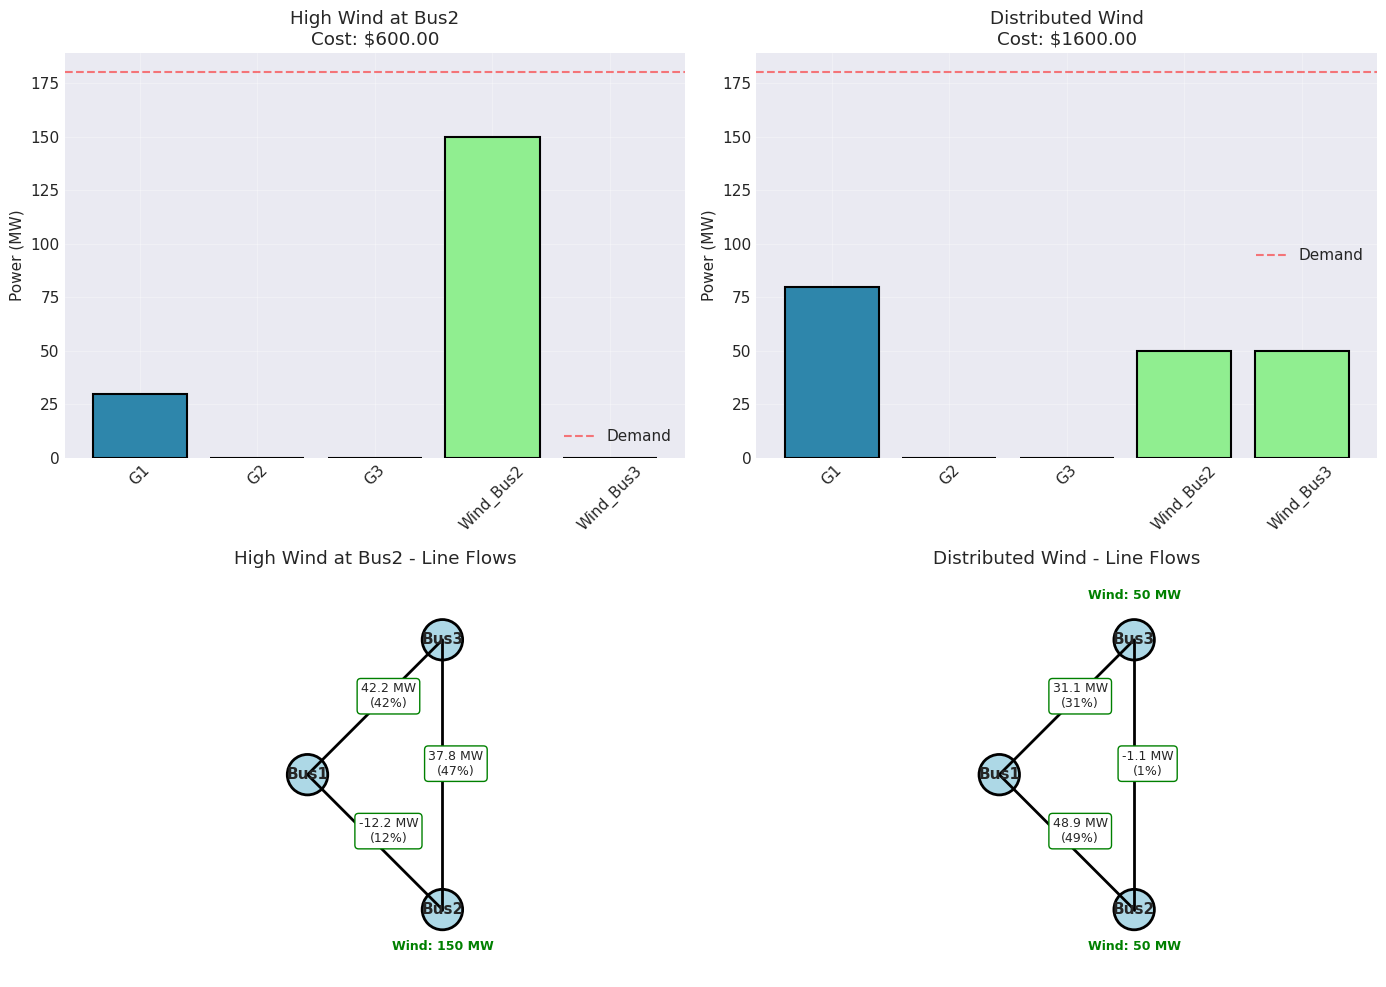

In [25]:
# Visualize the two scenarios side by side
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scenarios_list = [scenario_a, scenario_b]

for idx, scenario in enumerate(scenarios_list):
    result = results[scenario['name']]
    
    # Generation dispatch bar chart
    ax = axes[0, idx]
    
    # Prepare data for stacked bar chart
    gen_names = list(generators.index) + ['Wind_Bus2', 'Wind_Bus3']
    gen_values = result['thermal'] + result['wind_used']
    curtailed = result['wind_curtailed']
    
    # Create bars
    x = np.arange(len(gen_names))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#90EE90', '#90EE90']
    
    bars = ax.bar(x, gen_values, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add curtailment on top of wind bars (if any)
    if curtailed[0] > 0.1:
        ax.bar(3, curtailed[0], bottom=gen_values[3], 
               color='red', alpha=0.5, edgecolor='black', linewidth=1.5,
               label='Curtailed')
    if curtailed[1] > 0.1:
        ax.bar(4, curtailed[1], bottom=gen_values[4],
               color='red', alpha=0.5, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(x)
    ax.set_xticklabels(gen_names, rotation=45)
    ax.set_ylabel('Power (MW)')
    ax.set_title(f"{scenario['name']}\nCost: ${result['cost']:.2f}")
    ax.axhline(y=180, color='red', linestyle='--', alpha=0.5, label='Demand')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Network flow diagram
    ax_net = axes[1, idx]
    plot_network_flows(buses, lines, result['line_flows'], 
                      f"{scenario['name']} - Line Flows", ax_net)
    
    # Add wind indicators
    pos = {'Bus1': (0, 1), 'Bus2': (1, 0), 'Bus3': (1, 2)}
    
    if scenario['wind_bus2'] > 0:
        wind_text = f"Wind: {result['wind_used'][0]:.0f} MW"
        if result['wind_curtailed'][0] > 0.1:
            wind_text += f"\n(Curt: {result['wind_curtailed'][0]:.0f} MW)"
        ax_net.text(pos['Bus2'][0], pos['Bus2'][1] - 0.3, wind_text,
                   ha='center', fontsize=9, color='green', fontweight='bold')
    
    if scenario['wind_bus3'] > 0:
        wind_text = f"Wind: {result['wind_used'][1]:.0f} MW"
        if result['wind_curtailed'][1] > 0.1:
            wind_text += f"\n(Curt: {result['wind_curtailed'][1]:.0f} MW)"
        ax_net.text(pos['Bus3'][0], pos['Bus3'][1] + 0.3, wind_text,
                   ha='center', fontsize=9, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

### Key Insights from Renewable Integration Analysis

These scenarios reveal important principles for renewable energy integration:

**Transmission Flow Patterns Change Dramatically**: In Scenario A with 150 MW of wind at Bus2, line L1 operates in reverse (-12 MW) as Bus2 becomes a net exporter rather than importer. This complete reversal of traditional flow patterns is a major challenge for grid operators accustomed to unidirectional flows from central generation to load centers.

**Distributed Generation Reduces Transmission Stress**: Scenario B achieves the same renewable penetration but with much lower transmission utilization. L1 operates at only 49% capacity compared to potential congestion in Scenario A if wind were higher. This demonstrates why distributed renewable deployment can defer expensive transmission upgrades.

**Location Value Beyond Curtailment**: Even without curtailment, wind location significantly affects system operations. Scenario A requires G3 to provide 30 MW less than optimal due to transmission patterns, while Scenario B allows more economically efficient dispatch. The $1000 cost difference represents the hidden value of strategic renewable siting.

**Future Congestion Risk**: While neither scenario shows curtailment at current wind levels, Scenario A is much closer to creating transmission bottlenecks. As renewable penetration increases, concentrated deployment will hit transmission limits first, forcing either curtailment or expensive grid upgrades.

These results explain why modern grid planning increasingly emphasizes both renewable capacity AND strategic location to maximize the value of clean energy investments.

## Summary

This lesson demonstrated how network constraints fundamentally change power system optimization. Starting from simple economic dispatch, we progressively added transmission limits, contingency requirements, and renewable uncertainty to build increasingly realistic models. Each extension revealed new challenges: transmission constraints create locational price differences, N-1 security increases costs but ensures reliability, and renewable uncertainty requires stochastic formulations.

The techniques covered here - SCED, DC OPF, and stochastic optimization - form the computational foundation of modern electricity markets. These algorithms run continuously in grid control centers, processing vast amounts of data to maintain reliable and economical power delivery. As renewable penetration increases and grids become more interconnected, network-constrained optimization will only grow in importance.

Key takeaways include understanding why network constraints matter for reliable operation, implementing SCED using PTDF to linearize power flows, applying LODF for rapid contingency analysis, formulating DC OPF with voltage angle variables, and handling uncertainty through stochastic optimization. These concepts prepare you for advanced topics in electricity markets, transmission planning, and renewable integration studies.